## Exercise 1

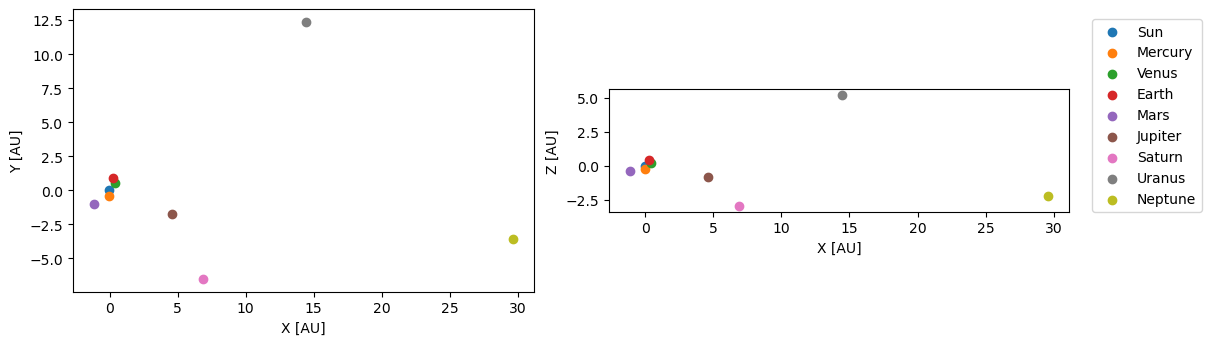

In [6]:
# we need to import the time module from astropy
from astropy.time import Time
# import some coordinate things from astropy
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Simulating the solar system

# pick a time (please use either this or the current time)
t = Time("2021-12-07 10:00")

## a)
# Initialize the planets and the Sun
with solar_system_ephemeris.set('jpl'):
    planets = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
    positions = {}
    for planet in planets:
        posvel = get_body_barycentric_posvel(planet, t)
        positions[planet] = posvel[0]

# Extract x, y, z positions
x = np.array([positions[planet].x.to_value(u.AU) for planet in planets])
y = np.array([positions[planet].y.to_value(u.AU) for planet in planets])
z = np.array([positions[planet].z.to_value(u.AU) for planet in planets])

# Define planet names
names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])

# Plotting (x, y) positions
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].scatter(x[i], y[i], label=obj)
    ax[1].scatter(x[i], z[i], label=obj)

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='X [AU]', ylabel='Z [AU]')

plt.legend(loc=(1.05, 0))
plt.savefig("fig1a.png")
plt.show() # da sostituire con plt.close()

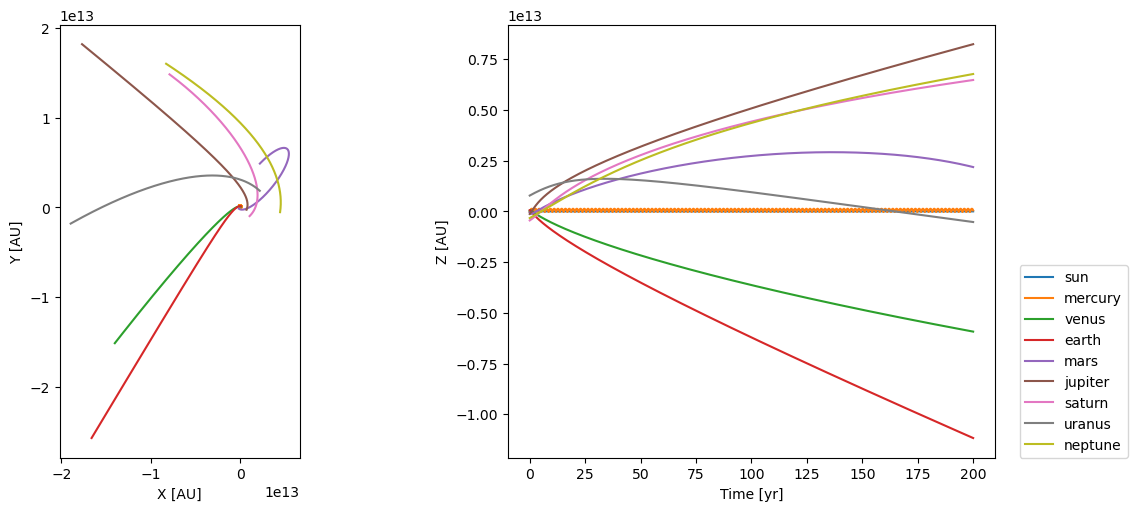

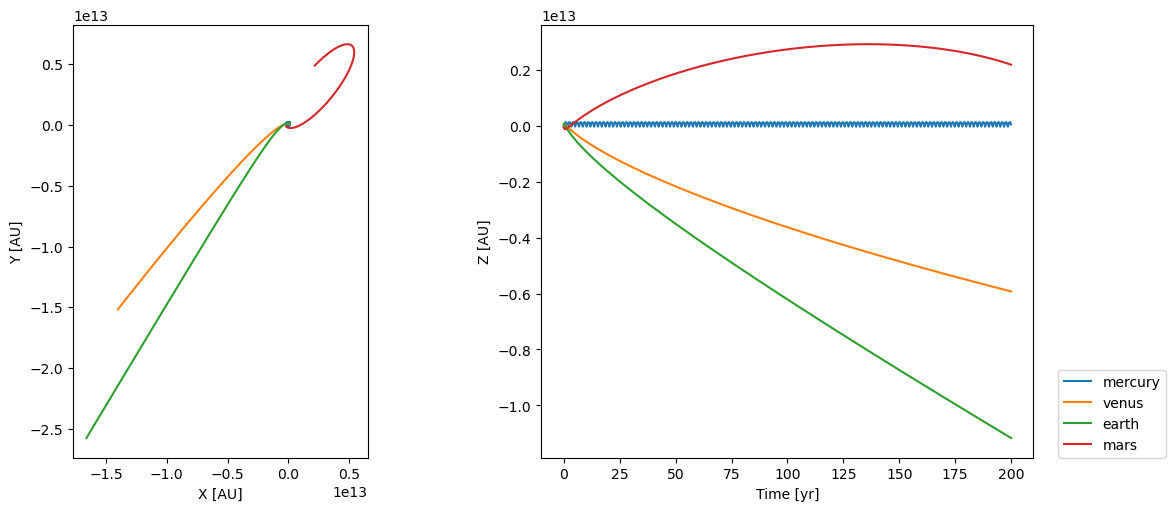

In [18]:
## b)
# Define necessary parameters and constants
G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
m_sun = 1.989e30  # mass of the Sun in kg

# Mass of the planets (in kg)
m_planet = {
    'mercury': 3.3011e23,
    'venus': 4.8675e24,
    'earth': 5.97237e24,
    'mars': 6.4171e23,
    'jupiter': 1.8982e27,
    'saturn': 5.6834e26,
    'uranus': 8.6810e25,
    'neptune': 1.02413e26
}

# Define function to calculate gravitational force between Sun and other planets
def gravitational_force(mass1, mass2, distance):
    return G * mass1 * mass2 / distance**2

# Initialize positions and velocities of the planets at t = 0
positions = {'sun': np.array([0.0, 0.0, 0.0])}  # Initialize Sun at origin
velocities = {'sun': np.array([0.0, 0.0, 0.0])}  # Initialize Sun's velocity as zero


# Compute initial positions and velocities of the planets at t = 0
with solar_system_ephemeris.set('builtin'):
    for planet in planets[1:]:  # Skip Sun
        posvel = get_body_barycentric_posvel(planet, t)
        positions[planet] = np.array([posvel[0].x.to_value(u.m), posvel[0].y.to_value(u.m), posvel[0].z.to_value(u.m)])
        velocities[planet] = np.array([posvel[1].x.to_value(u.m/u.s), posvel[1].y.to_value(u.m/u.s), posvel[1].z.to_value(u.m/u.s)])

# Leapfrog algorithm to calculate positions and velocities of the planets
time_steps = 200 * 365 * 2  # 200 years with a time step of 0.5 days
dt = 0.5 * 24 * 3600  # time step in seconds
positions_history = {'sun': [], 'mercury': [], 'venus': [], 'earth': [], 'mars': [], 'jupiter': [], 'saturn': [], 'uranus': [], 'neptune': []}

for step in range(time_steps):
    # Update velocities (v_i+1/2)
    for planet in planets:
        if planet == 'sun':
            continue
        # Calculate acceleration due to gravitational force from the Sun
        r = positions[planet] - positions['sun']
        r_mag = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
        acceleration = - gravitational_force(m_sun, m_planet[planet], r_mag) * r / r_mag / m_planet[planet]
        velocities[planet] += acceleration * dt / 2

    # Update positions (x_i+1)
    for planet in planets:
        positions[planet] += velocities[planet] * dt

    # Store positions for plotting
    for planet in planets:
        positions_history[planet].append(positions[planet].copy())

""" # Plot the orbits of all objects in the x-y plane
plt.figure(figsize=(8, 6))
for planet in planets:
    if planet != 'sun':
        x = [pos[0] for pos in positions_history[planet]]
        y = [pos[1] for pos in positions_history[planet]]
        plt.plot(x, y, label=planet)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Orbits of Solar System Objects in X-Y Plane')
plt.legend()
plt.grid(True)
plt.show()

# Plot time versus position in the z plane
plt.figure(figsize=(8, 6))
time = np.arange(0, time_steps * dt, dt)
for planet in planets:
    if planet != 'sun':
        z = [pos[2] for pos in positions_history[planet]]
        plt.plot(time, z, label=planet)
plt.xlabel('Time (s)')
plt.ylabel('Z (m)')
plt.title('Time versus Position in Z Plane')
plt.legend()
plt.grid(True)
plt.show() """

# Convert positions_history to arrays for easier manipulation
for planet in planets:
    positions_history[planet] = np.array(positions_history[planet])

# Extract x, y, z coordinates for all planets
x = [positions_history[planet][:, 0] for planet in planets]
y = [positions_history[planet][:, 1] for planet in planets]
z = [positions_history[planet][:, 2] for planet in planets]

# Convert time to years
time = np.linspace(0, 200, time_steps)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot x-y plane for all planets
for i, planet in enumerate(planets):
    ax[0].plot(x[i], y[i], label=planet)

# Plot time versus z plane for all planets
for i, planet in enumerate(planets):
    ax[1].plot(time, z[i], label=planet)

# Set labels and title
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]')

# Show legend
plt.legend(loc=(1.05, 0))

# Save figure
plt.savefig("fig1b.png")

# Close figure
plt.show()


# Create subplots - INNER ZOOM
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# List of inner planets
inner_planets = ['mercury', 'venus', 'earth', 'mars']

# Plot x-y plane for inner planets
for planet in inner_planets:
    i = planets.index(planet)
    ax[0].plot(x[i], y[i], label=planet)

# Plot time versus z plane for inner planets
for planet in inner_planets:
    i = planets.index(planet)
    ax[1].plot(time, z[i], label=planet)

# Set labels and title
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]')

# Show legend
plt.legend(loc=(1.05, 0))

# Save figure
plt.savefig("fig1b_inner.png")

# Close figure
plt.show()

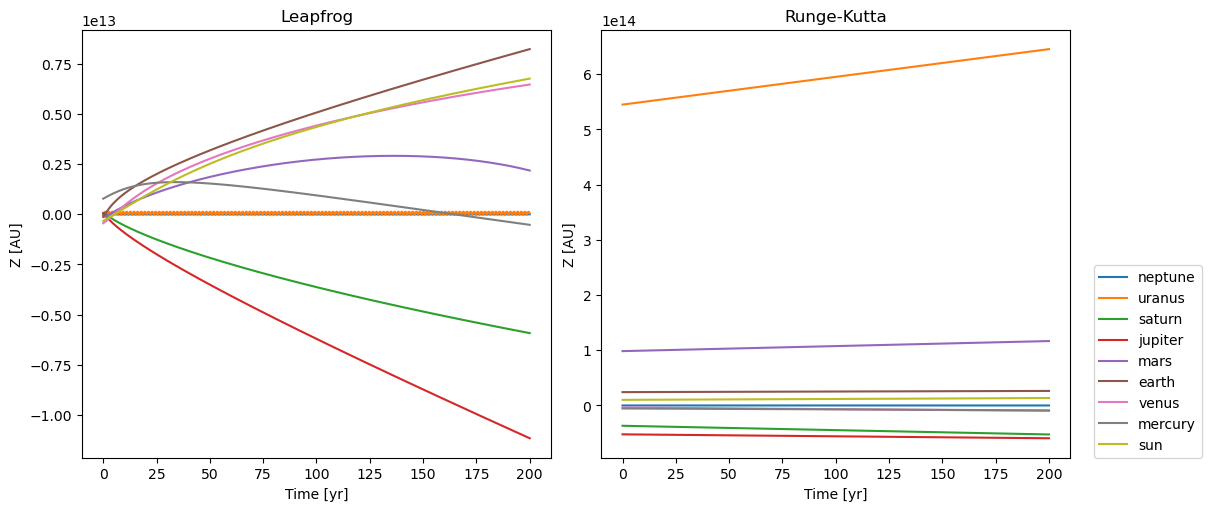

' \n# Create subplots\nfig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)\n\n# Plot x-y plane for all planets\nfor i, planet in enumerate(planets):\n    ax[0].plot(x_rk[i], y_rk[i], label=planet)\n\n# Plot time versus z plane for all planets\nfor i, planet in enumerate(planets):\n    ax[1].plot(time, z_rk[i], label=planet)\n\n# Set labels and title\nax[0].set_aspect(\'equal\', \'box\')\nax[0].set(xlabel=\'X [AU]\', ylabel=\'Y [AU]\')\nax[1].set(xlabel=\'Time [yr]\', ylabel=\'Z [AU]\')\n\n# Show legend\nplt.legend(loc=(1.05, 0))\n\n# Save figure\nplt.savefig("fig1b_rk.png")\n\n# Close figure\nplt.close()\n\n# Plot difference in the bodies\' x positions versus time for both methods\nplt.figure(figsize=(8, 6))\nfor i, planet in enumerate(planets):\n    diff_x = x[i] - x_rk[i]\n    plt.plot(time, diff_x, label=planet)\nplt.xlabel(\'Time [s]\')\nplt.ylabel(\'Difference in X [m]\')\nplt.title(\'Difference in X Positions versus Time\')\nplt.legend()\nplt.grid(True)\nplt.sa

In [25]:
## c)

# Initialize positions and velocities for Runge-Kutta method
positions_rk = positions.copy()
velocities_rk = velocities.copy()

# Initialize history for Runge-Kutta method
positions_history_rk = {planet: [] for planet in planets}

# Runge-Kutta algorithm to calculate positions and velocities of the planets
for step in range(time_steps):
    # Store positions for plotting
    for planet in planets:
        positions_history_rk[planet].append(positions_rk[planet].copy())

    # Update positions and velocities using Runge-Kutta method
    for planet in planets:
        if planet == 'sun':
            continue
        # Calculate acceleration due to gravitational force from the Sun
        r = positions_rk[planet] - positions_rk['sun']
        r_mag = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
        a = gravitational_force(m_sun, m_planet[planet], r_mag) * r / r_mag / m_planet[planet]
        
        # Runge-Kutta method
        k1_x = velocities_rk[planet] * dt
        k1_v = a * dt
        
        k2_x = (velocities_rk[planet] + 0.5 * k1_v) * dt
        k2_v = a * dt
        
        k3_x = (velocities_rk[planet] + 0.5 * k2_v) * dt
        k3_v = a * dt
        
        k4_x = (velocities_rk[planet] + k3_v) * dt
        k4_v = a * dt
        
        positions_rk[planet] += (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        velocities_rk[planet] += (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6


# Convert positions_history to arrays for easier manipulation
for planet in planets:
    positions_history_rk[planet] = np.array(positions_history_rk[planet])

# Extract x, y, z coordinates for all planets
x_rk = [positions_history_rk[planet][:, 0] for planet in planets]
y_rk = [positions_history_rk[planet][:, 1] for planet in planets]
z_rk = [positions_history_rk[planet][:, 2] for planet in planets]

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot time versus z plane for all planets using Leapfrog method
for i, planet in enumerate(reversed(planets)):
    ax[0].plot(time, z[i], label=planet)

# Plot time versus z plane for all planets using Runge-Kutta method
for i, planet in enumerate(reversed(planets)):
    ax[1].plot(time, z_rk[i], label=planet)

# Set labels and title
ax[0].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Leapfrog')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Runge-Kutta')

# Show legend
plt.legend(loc=(1.05, 0))

# Save figure
plt.savefig("fig1c.png")

# Close figure
plt.show()

# DA CONTROLLARE
""" 
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot x-y plane for all planets
for i, planet in enumerate(planets):
    ax[0].plot(x_rk[i], y_rk[i], label=planet)

# Plot time versus z plane for all planets
for i, planet in enumerate(planets):
    ax[1].plot(time, z_rk[i], label=planet)

# Set labels and title
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]')

# Show legend
plt.legend(loc=(1.05, 0))

# Save figure
plt.savefig("fig1b_rk.png")

# Close figure
plt.close()

# Plot difference in the bodies' x positions versus time for both methods
plt.figure(figsize=(8, 6))
for i, planet in enumerate(planets):
    diff_x = x[i] - x_rk[i]
    plt.plot(time, diff_x, label=planet)
plt.xlabel('Time [s]')
plt.ylabel('Difference in X [m]')
plt.title('Difference in X Positions versus Time')
plt.legend()
plt.grid(True)
plt.savefig("fig1b_diff_x.png")
plt.close() """

## Exercise 2

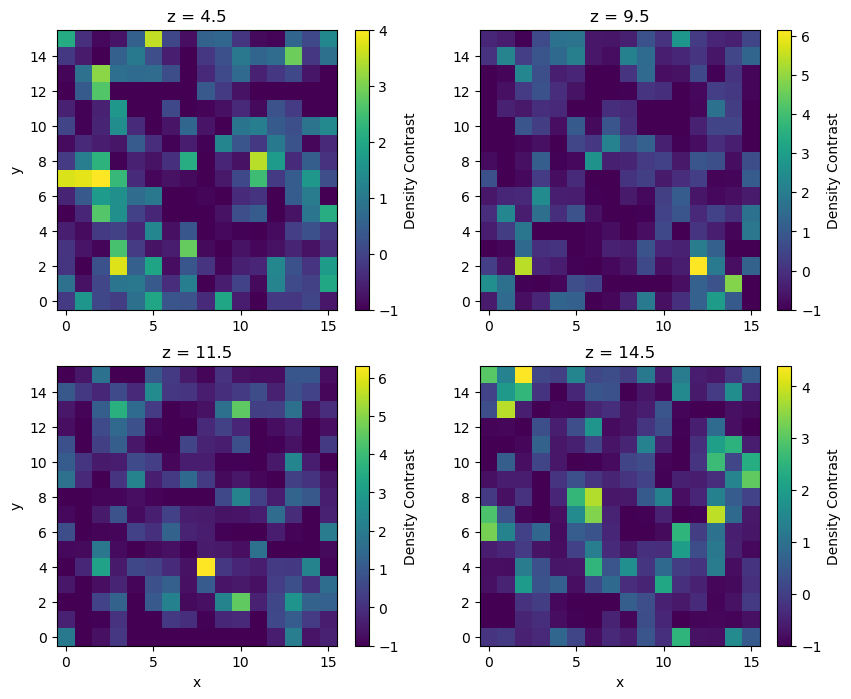

In [26]:
# Question 2: Calculating forces with the FFT

np.random.seed(121) # DO NOT CHANGE (so positions are the same for all students)

n_mesh = 16
n_part = 1024
positions = np.random.uniform(low=0, high=n_mesh, size=(3, n_part))

grid = np.arange(n_mesh) + 0.5
densities = np.zeros(shape=(n_mesh, n_mesh, n_mesh))
cellvol = 1.

for p in range(n_part):
    cellind = np.zeros(shape=(3, 2))
    dist = np.zeros(shape=(3, 2))

    for i in range(3):
        cellind[i] = np.where((abs(positions[i, p] - grid) < 1) |
                              (abs(positions[i, p] - grid - 16) < 1) | 
                              (abs(positions[i, p] - grid + 16) < 1))[0]
        dist[i] = abs(positions[i, p] - grid[cellind[i].astype(int)])

    cellind = cellind.astype(int)

    for (x, dx) in zip(cellind[0], dist[0]):    
        for (y, dy) in zip(cellind[1], dist[1]):
            for (z, dz) in zip(cellind[2], dist[2]):
                if dx > 15: dx = abs(dx - 16)
                if dy > 15: dy = abs(dy - 16)
                if dz > 15: dz = abs(dz - 16)

                densities[x, y, z] += (1 - dx)*(1 - dy)*(1 - dz) / cellvol

## a)
# Calculate the mean density
rho_mean = n_part / (n_mesh ** 3)

# Calculate the density contrast
density_contrast = (densities - rho_mean) / rho_mean

# Now you can use this density contrast in your plots
fig, ax = plt.subplots(2,2, figsize=(10,8))

# For z = 4.5, we take the slice at index 4
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Density Contrast')

# For z = 9.5, we take the slice at index 9
pcm = ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Density Contrast')

# For z = 11.5, we take the slice at index 11
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Density Contrast')

# For z = 14.5, we take the slice at index 14
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Density Contrast')

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')

plt.savefig("fig2a.png")
plt.show()

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_20247/3509167734.py:29: RuntimeWarning: divide by zero encountered in divide
  potential_transformed = density_contrast_ft / k_squared
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_20247/3509167734.py:29: RuntimeWarning: invalid value encountered in divide
  potential_transformed = density_contrast_ft / k_squared
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_20247/3509167734.py:21: RuntimeWarning: invalid value encountered in divide
  return [(even[k] + T[k])/N for k in range(N//2)] + [(even[k] - T[k])/N for k in range(N//2)]


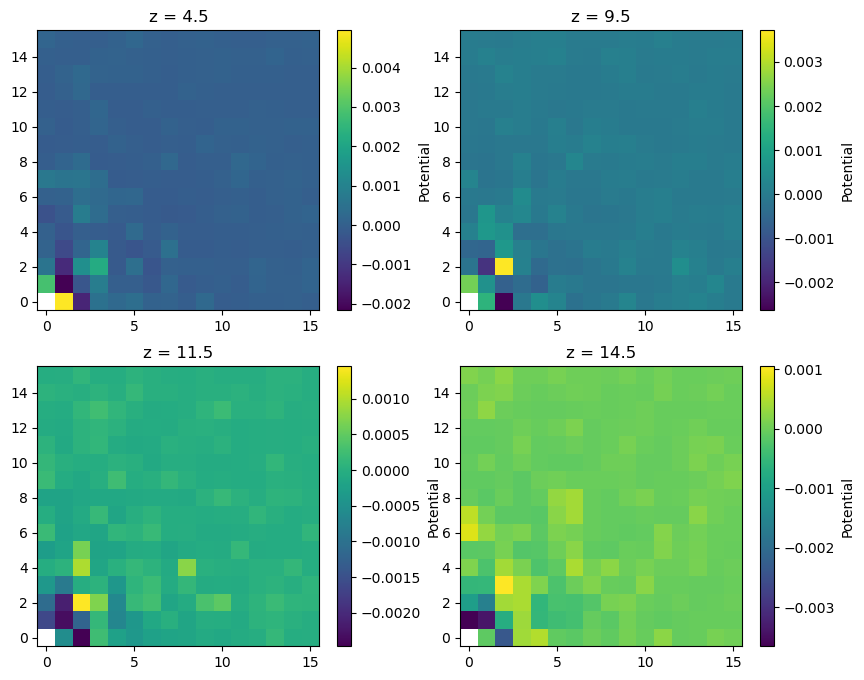

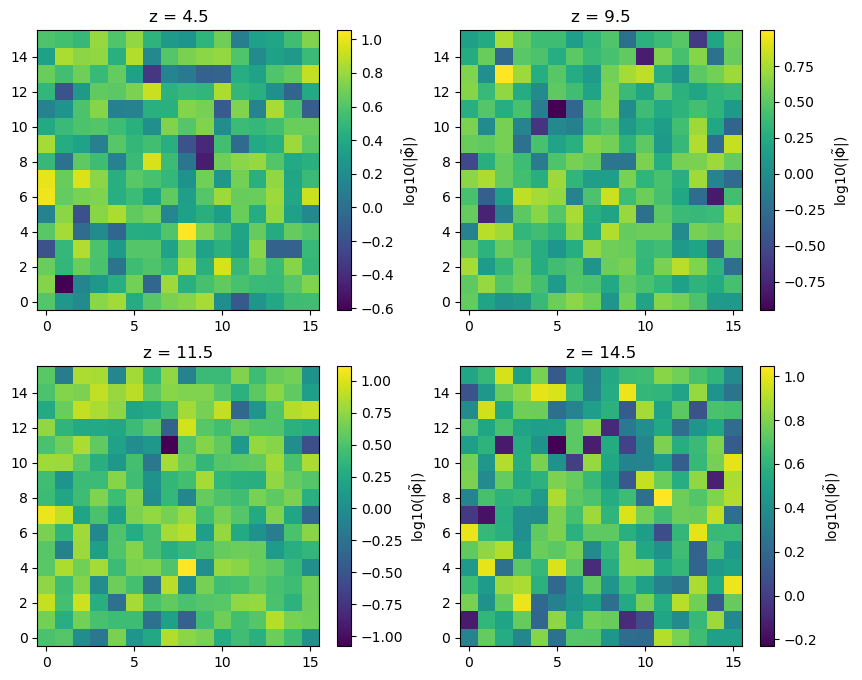

In [29]:
## b)
# Define the FFT using Cooley-Tukey algorithm
# Recursively (no-bit reversal needed)
def fft(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft(x[0::2])
    odd =  fft(x[1::2])
    T= [np.exp(-2j*np.pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

# Define the inverse FFT
def ifft(x):
    N = len(x)
    if N <= 1:
        return x
    even = ifft(x[0::2])
    odd =  ifft(x[1::2])
    T= [np.exp(2j*np.pi*k/N)*odd[k] for k in range(N//2)]
    return [(even[k] + T[k])/N for k in range(N//2)] + [(even[k] - T[k])/N for k in range(N//2)]

# Compute the Fourier transform of the density contrast
density_contrast_ft = fft(density_contrast)

# Compute the transformed potential
k = np.arange(n_mesh)
k_squared = np.meshgrid(k, k, k)[0]**2 + np.meshgrid(k, k, k)[1]**2 + np.meshgrid(k, k, k)[2]**2
potential_transformed = density_contrast_ft / k_squared 

# Get the real potential from the transformed potential
potential = ifft(potential_transformed)

# Replace 'potential' and 'fourier_potential' with your calculated values
potential = np.real(ifft(potential_transformed)) # Take the real part (check if it can be used)
fourier_potential = np.abs(density_contrast_ft) 

# Plotting the potential
fig, ax = plt.subplots(2,2, figsize=(10,8))
for i, z in enumerate([4, 9, 11, 14]):
    pcm = ax[i//2, i%2].pcolormesh(np.arange(0,16), np.arange(0,16), potential[z])
    ax[i//2, i%2].set(title=f'z = {z + 0.5}')
    fig.colorbar(pcm, ax=ax[i//2, i%2], label='Potential')
plt.savefig("fig2b_pot.png")
plt.show()

# Plotting the Fourier-transformed potential
fig, ax = plt.subplots(2,2, figsize=(10,8))
for i, z in enumerate([4, 9, 11, 14]):
    pcm = ax[i//2, i%2].pcolormesh(np.arange(0,16), np.arange(0,16), np.log10(fourier_potential[z]))
    ax[i//2, i%2].set(title=f'z = {z + 0.5}')
    fig.colorbar(pcm, ax=ax[i//2, i%2], label=r'log10(|$\~\Phi$|)')
plt.savefig("fig2b_fourier.png")
plt.show() 

## Exercise 3
Logistic regression to classify galaxies into spirals and ellipticals
Cols in the file:
- 1: κ_co, a parameter indicating how much a galaxy is dominated by ordered rotation
- 2: estimate of their color, where higher values correspond to redder colours (i.e., older stellar populations)
- 3: measure of how extended each galaxy is
- 4:  the flux of an emission line used to measure the star formation rate of galaxies
- 5: morphology flag: 1 for spirals and 0 for ellipticals

In [30]:
import csv
import matplotlib.pyplot as plt
import numpy as np

# Load galaxy data from text file
with open('galaxy_data.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    data = list(reader)

# Convert data to float
data = [[float(j) for j in i] for i in data]

# Transpose data for easier manipulation
data = list(map(list, zip(*data)))

# Apply feature scaling to have features with mean 0 and standard deviation 1
scaled_data = []
for feature in data:
    mean = sum(feature) / len(feature)
    std_dev = (sum((x - mean) ** 2 for x in feature) / len(feature)) ** 0.5
    scaled_feature = [(x - mean) / std_dev for x in feature]
    scaled_data.append(scaled_feature)

# Transpose scaled data back to original format
scaled_data = list(map(list, zip(*scaled_data)))

# Save the scaled features to a text file
with open('scaled_features.txt', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(scaled_data)

# Print the features for the first 10 objects
for row in scaled_data[:10]:
    print(row)

# Plot the distributions of the rescaled features
for i, feature in enumerate(scaled_data):
    plt.figure(i)
    plt.hist(feature, bins=50)
    plt.title('Feature ' + str(i+1))
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'galaxy_data.txt'

## Provided routines

In [ ]:
# PROVIDED CODE


# we need to import the time module from astropy
from astropy.time import Time
# import some coordinate things from astropy
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Simulating the solar system

# pick a time (please use either this or the current time)
t = Time("2021-12-07 10:00")

# initialize the planets; Mars is shown as an example
with solar_system_ephemeris.set('jpl'):
    mars = get_body_barycentric_posvel('mars', t)
    
print(mars)

marsposition = mars[0]
marsvelocity = mars[1]

# calculate the x position in AU
print(marsposition.x.to_value(u.AU))

# calculate the v_x velocity in AU/day
print(marsvelocity.x.to_value(u.AU/u.d))

# Problem 1.a
x, y, z = np.random.rand(3,9)*10-5 # REPLACE
names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].scatter(x[i], y[i], label=obj)
    ax[1].scatter(x[i], z[i], label=obj)
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='X [AU]', ylabel='Z [AU]')
plt.legend(loc=(1.05,0))
plt.savefig("fig1a.png")
plt.close()

# Problem 1.b
# For visibility, you may want to do two versions of this plot: 
# one with all planets, and another zoomed in on the four inner planets
x, y, z = np.random.rand(3,9,10)*10-5 # REPLACE
time = x.copy()*0 +np.linspace(0,200,10) # REPLACE
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].plot(x[i,:], y[i,:], label=obj)
    ax[1].plot(time[i,:], z[i,:], label=obj)
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]')
plt.legend(loc=(1.05,0))
plt.savefig("fig1b.png")
plt.close()


# Bonus problem 1.c
x, y, z = np.random.rand(3,9,10)*10-5 # REPLACE
time = x.copy()*0 +np.linspace(0,200,10) # REPLACE
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(np.flip(names)):
    ax[0].plot(time[i,:], z[i,:], label=obj)
    ax[1].plot(time[i,:], z[i,:], label=obj)
ax[0].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Leapfrog')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Other method')
plt.legend(loc=(1.05,0))
plt.savefig("fig1c.png")
plt.close()


import numpy as np
import matplotlib.pyplot as plt

# Question 2: Calculating forces with the FFT

np.random.seed(121) # DO NOT CHANGE (so positions are the same for all students)

n_mesh = 16
n_part = 1024
positions = np.random.uniform(low=0, high=n_mesh, size=(3, n_part))

grid = np.arange(n_mesh) + 0.5
densities = np.zeros(shape=(n_mesh, n_mesh, n_mesh))
cellvol = 1.

for p in range(n_part):
    cellind = np.zeros(shape=(3, 2))
    dist = np.zeros(shape=(3, 2))

    for i in range(3):
        cellind[i] = np.where((abs(positions[i, p] - grid) < 1) |
                              (abs(positions[i, p] - grid - 16) < 1) | 
                              (abs(positions[i, p] - grid + 16) < 1))[0]
        dist[i] = abs(positions[i, p] - grid[cellind[i].astype(int)])

    cellind = cellind.astype(int)

    for (x, dx) in zip(cellind[0], dist[0]):    
        for (y, dy) in zip(cellind[1], dist[1]):
            for (z, dz) in zip(cellind[2], dist[2]):
                if dx > 15: dx = abs(dx - 16)
                if dy > 15: dy = abs(dy - 16)
                if dz > 15: dz = abs(dz - 16)

                densities[x, y, z] += (1 - dx)*(1 - dy)*(1 - dz) / cellvol

# Problem 2.a
densitycontrast = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Density')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Density')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Density')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Density')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2a.png")
plt.close()

# Problem 2.b
potential = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), potential[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Potential')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), potential[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Potential')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), potential[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Potential')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), potential[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Potential')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2b_pot.png")
plt.close()

fourier_potential = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label=r'log10(|$\~\Phi$|)')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label=r'log10(|$\~\Phi$|)')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label=r'log10(|$\~\Phi$|)')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label=r'log10(|$\~\Phi$|)')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2b_fourier.png")
plt.close()